In [1]:
import os
import numpy as np
import pandas as pd
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader, random_split, Subset
from torchvision import transforms, models
from sklearn.metrics import confusion_matrix, accuracy_score
import matplotlib.pyplot as plt
from PIL import Image
import seaborn as sns
import random


# Define the custom dataset
class CustomDataset(Dataset):
    def __init__(self, annotations_file, images_dir, masks_dir, transform=None):
        self.annotations = pd.read_csv(annotations_file)
        self.images_dir = images_dir
        self.masks_dir = masks_dir
        self.transform = transform

    def __len__(self):
        return len(self.annotations)

    def __getitem__(self, idx):
        row = self.annotations.iloc[idx]
        image_id = row["image_id"]
        label = row["label"]
        bbox = eval(row["bbox"])  # Convert string list to Python list

        # Load image and mask
        image_path = os.path.join(self.images_dir, f"{image_id}.jpg")
        mask_path = os.path.join(self.masks_dir, f"{image_id}.png")
        image = Image.open(image_path).convert("RGB")
        mask = Image.open(mask_path).convert("L")

        if self.transform:
            image = self.transform(image)
            mask = self.transform(mask)

        return image, mask, torch.tensor(bbox, dtype=torch.float32), label


class CNNModel(nn.Module):
    def __init__(self, num_classes=10):
        super(CNNModel, self).__init__()
        self.backbone = models.resnet18(pretrained=True)
        in_features = self.backbone.fc.in_features  # Store in_features before replacing fc
        self.backbone.fc = nn.Identity()  # Remove the final classification layer

        # Add custom layers for classification, mask, and bbox prediction
        self.classifier = nn.Linear(in_features, num_classes)  # Classification
        self.mask_decoder = nn.Sequential(
            nn.ConvTranspose2d(512, 256, kernel_size=2, stride=2),  # Upsample to 2x2
            nn.ReLU(),
            nn.ConvTranspose2d(256, 128, kernel_size=2, stride=2),  # Upsample to 4x4
            nn.ReLU(),
            nn.ConvTranspose2d(128, 64, kernel_size=2, stride=2),   # Upsample to 8x8
            nn.ReLU(),
            nn.ConvTranspose2d(64, 1, kernel_size=16, stride=16),   # Upsample to 128x128
        )
        self.bbox_decoder = nn.Linear(in_features, 4)  # Bounding Box Regression

    def forward(self, x):
        # Extract features from the backbone
        features = self.backbone(x)
        logits = self.classifier(features)

        # Prepare for mask generation
        mask_features = features.view(features.size(0), 512, 1, 1)  # Reshape to 4D tensor
        masks = self.mask_decoder(mask_features)

        # Bounding box prediction
        bboxes = self.bbox_decoder(features)

        return logits, masks, bboxes



In [2]:
# Initialize model, loss functions, and optimizer
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model = CNNModel(num_classes=10).to(device)
criterion_class = nn.CrossEntropyLoss()
criterion_mask = nn.BCEWithLogitsLoss()
criterion_bbox = nn.MSELoss()
optimizer = optim.Adam(model.parameters(), lr=0.001)

c:\Users\Dell\AppData\Local\Programs\Python\Python312\Lib\site-packages\torchvision\models\_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
c:\Users\Dell\AppData\Local\Programs\Python\Python312\Lib\site-packages\torchvision\models\_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet18_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet18_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


In [3]:
model

CNNModel(
  (backbone): ResNet(
    (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
    (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (relu): ReLU(inplace=True)
    (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
    (layer1): Sequential(
      (0): BasicBlock(
        (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
        (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (relu): ReLU(inplace=True)
        (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
        (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      )
      (1): BasicBlock(
        (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
        (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_r

In [5]:
# Define transforms
transform = transforms.Compose([
    transforms.Resize((128, 128)),
    transforms.ToTensor(),
])

# Dataset and DataLoader
annotations_file = r"C:\Users\Dell\Downloads\coco_dataset\car_train\full_bbox_white.csv"
images_dir = r"C:\Users\Dell\Downloads\coco_dataset\car_train\cropped_car"
masks_dir = R"C:\Users\Dell\Downloads\coco_dataset\car_train\cropped_mask"

# Create the full dataset
dataset = CustomDataset(annotations_file, images_dir, masks_dir, transform=transform)

# Randomly select 2000 samples from the dataset
random_indices = random.sample(range(len(dataset)), 112510)
dataset_subset = Subset(dataset, random_indices)

# Train-Test Split
train_size = int(0.8 * len(dataset_subset))
test_size = len(dataset_subset) - train_size
train_dataset, test_dataset = torch.utils.data.random_split(dataset_subset, [train_size, test_size])

train_loader = DataLoader(train_dataset, batch_size=32, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=32, shuffle=False)


In [6]:
len(train_loader), len(test_loader)

(2813, 704)

In [7]:
len(train_dataset), len(test_dataset)

(90008, 22502)

In [8]:
# Training loop
epochs = 20
train_losses, train_accuracies = [], []

for epoch in range(epochs):
    model.train()
    running_loss = 0.0
    correct, total = 0, 0

    for images, masks, bboxes, labels in train_loader:
        images, masks, bboxes, labels = images.to(device), masks.to(device), bboxes.to(device), labels.to(device)

        # Forward pass
        logits, pred_masks, pred_bboxes = model(images)
        loss_class = criterion_class(logits, labels)
        loss_mask = criterion_mask(pred_masks, masks)
        loss_bbox = criterion_bbox(pred_bboxes, bboxes)
        loss = loss_class + loss_mask + loss_bbox
        running_loss += loss.item()

        # Backward pass
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        # Accuracy
        _, preds = torch.max(logits, 1)
        correct += (preds == labels).sum().item()
        total += labels.size(0)

    train_loss = running_loss / len(train_loader)
    train_accuracy = correct / total
    train_losses.append(train_loss)
    train_accuracies.append(train_accuracy)

    print(f"Epoch {epoch + 1}/{epochs}, Loss: {train_loss:.4f}, Accuracy: {train_accuracy:.4f}")

    

Epoch 1/20, Loss: 4674.0417, Accuracy: 0.1420
Epoch 2/20, Loss: 1844.6759, Accuracy: 0.1774
Epoch 3/20, Loss: 1491.8037, Accuracy: 0.1825
Epoch 4/20, Loss: 1184.5565, Accuracy: 0.1864
Epoch 5/20, Loss: 899.2825, Accuracy: 0.1882
Epoch 6/20, Loss: 678.6606, Accuracy: 0.1906
Epoch 7/20, Loss: 529.9546, Accuracy: 0.1957
Epoch 8/20, Loss: 422.8527, Accuracy: 0.2005
Epoch 9/20, Loss: 369.2982, Accuracy: 0.2046
Epoch 10/20, Loss: 303.7011, Accuracy: 0.2084
Epoch 11/20, Loss: 276.6586, Accuracy: 0.2139
Epoch 12/20, Loss: 245.3720, Accuracy: 0.2190
Epoch 13/20, Loss: 221.4591, Accuracy: 0.2250
Epoch 14/20, Loss: 193.1166, Accuracy: 0.2286
Epoch 15/20, Loss: 200.0946, Accuracy: 0.2323
Epoch 16/20, Loss: 166.1630, Accuracy: 0.2375
Epoch 17/20, Loss: 163.4027, Accuracy: 0.2405
Epoch 18/20, Loss: 157.0841, Accuracy: 0.2465
Epoch 19/20, Loss: 153.3846, Accuracy: 0.2510
Epoch 20/20, Loss: 145.0800, Accuracy: 0.2515


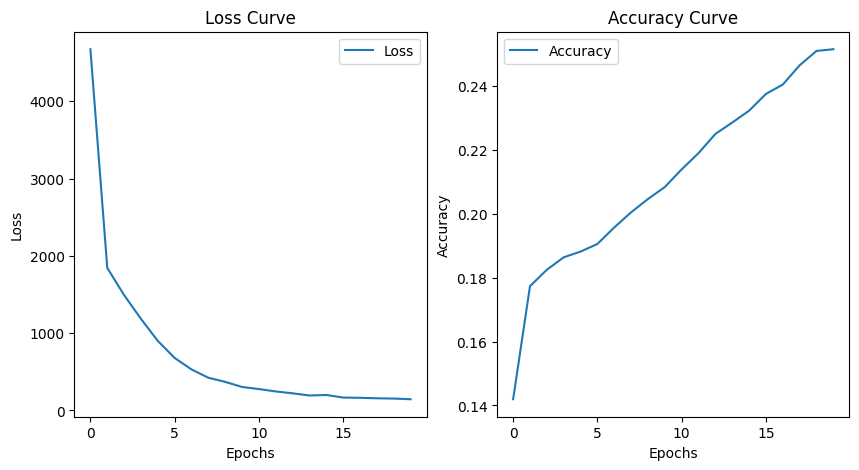

In [9]:

# Plot loss and accuracy curves
plt.figure(figsize=(10, 5))
plt.subplot(1, 2, 1)
plt.plot(train_losses, label="Loss")
plt.title("Loss Curve")
plt.xlabel("Epochs")
plt.ylabel("Loss")
plt.legend()

plt.subplot(1, 2, 2)
plt.plot(train_accuracies, label="Accuracy")
plt.title("Accuracy Curve")
plt.xlabel("Epochs")
plt.ylabel("Accuracy")
plt.legend()
plt.show()



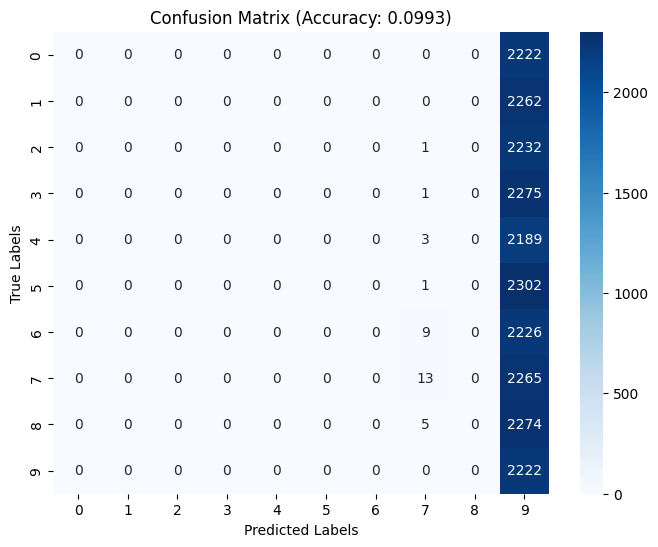

In [10]:
# Testing loop with visualization
model.eval()
all_preds, all_labels = [], []
test_samples = []

with torch.no_grad():
    for images, masks, bboxes, labels in test_loader:
        images, masks, bboxes, labels = images.to(device), masks.to(device), bboxes.to(device), labels.to(device)
        logits, pred_masks, pred_bboxes = model(images)

        _, preds = torch.max(logits, 1)
        all_preds.extend(preds.cpu().numpy())
        all_labels.extend(labels.cpu().numpy())

        # Store samples for visualization
        if len(test_samples) < 10:
            test_samples.extend(
                zip(
                    images.cpu(),
                    masks.cpu(),
                    bboxes.cpu(),
                    labels.cpu(),
                    preds.cpu(),
                    pred_masks.cpu(),
                    pred_bboxes.cpu(),
                )
            ) 
# Accuracy and confusion matrix
test_accuracy = accuracy_score(all_labels, all_preds)
conf_matrix = confusion_matrix(all_labels, all_preds)

# Plot the confusion matrix using Seaborn
plt.figure(figsize=(8, 6))
sns.heatmap(conf_matrix, annot=True, fmt="d", cmap="Blues", xticklabels=True, yticklabels=True)

# Add labels, title, and accuracy
plt.xlabel("Predicted Labels")
plt.ylabel("True Labels")
plt.title(f"Confusion Matrix (Accuracy: {test_accuracy:.4f})")
plt.show()



Sample 1:
  True BBox: [ 86. 129.  52.   9.], Predicted BBox: [ 16.122896  23.805077 594.0658   473.19806 ]


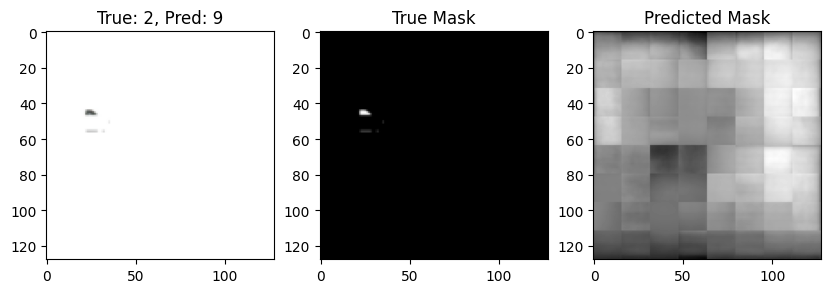

Sample 2:
  True BBox: [  0. 247.  80.  72.], Predicted BBox: [ 12.685711  28.09626  598.229    458.57108 ]


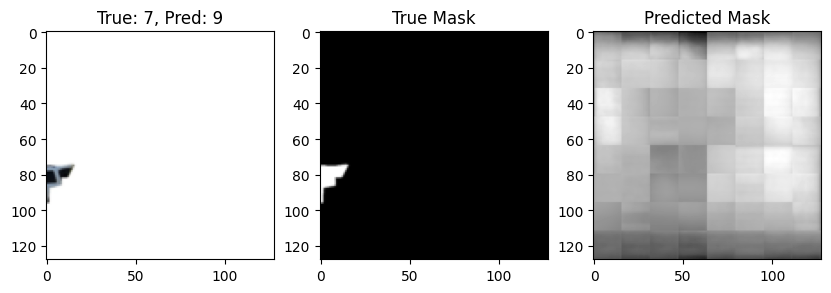

Sample 3:
  True BBox: [  0. 174.  30.  14.], Predicted BBox: [ 14.28104   28.452675 599.1261   475.21265 ]


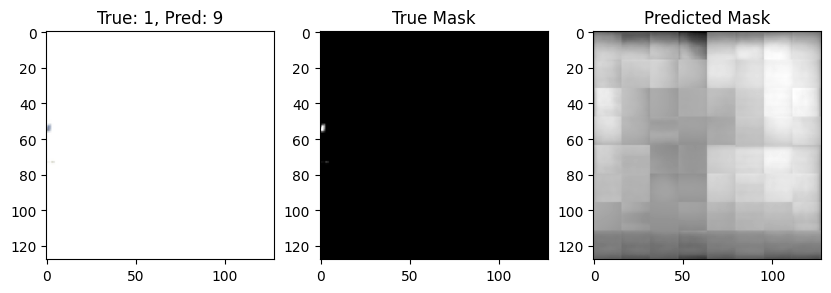

Sample 4:
  True BBox: [383. 348. 256. 117.], Predicted BBox: [ 17.714607  22.27192  601.0525   488.81317 ]


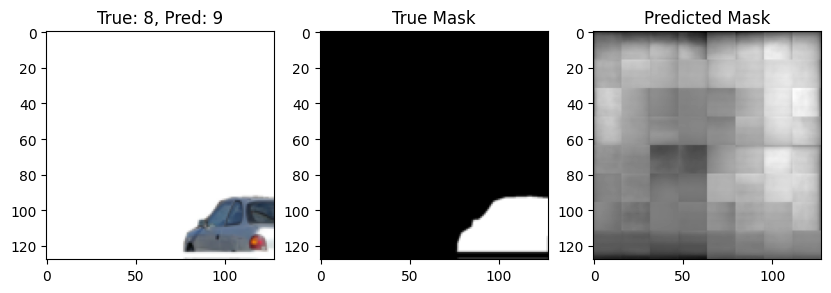

Sample 5:
  True BBox: [335. 147.  34.  10.], Predicted BBox: [ 16.111864  36.10178  543.72253  499.4964  ]


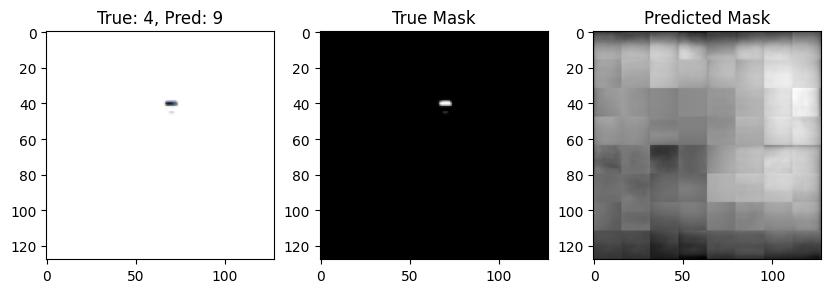

Sample 6:
  True BBox: [276. 353.  59.  12.], Predicted BBox: [ 17.200459  28.2846   591.4591   464.42017 ]


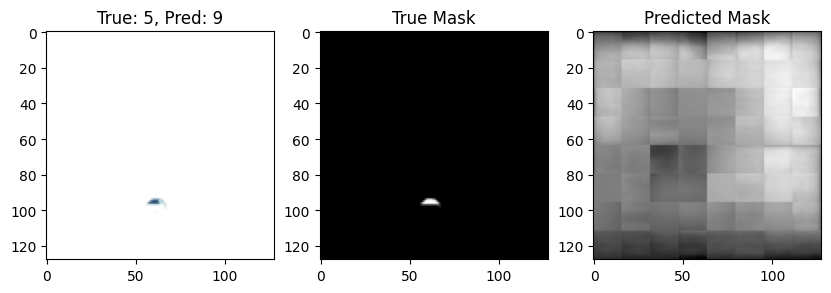

Sample 7:
  True BBox: [  0.   0. 408. 100.], Predicted BBox: [  7.5537558  11.587941  598.83734   458.44815  ]


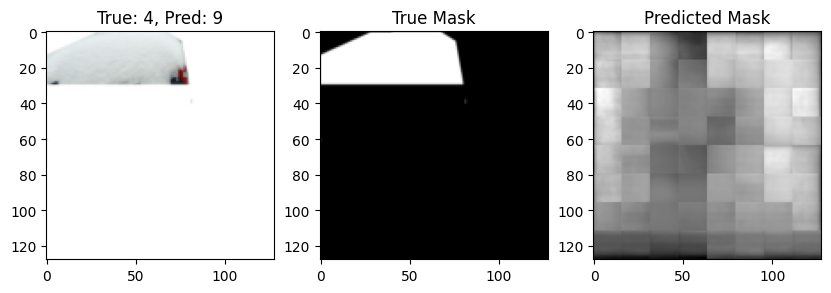

Sample 8:
  True BBox: [  0.   0. 590.  36.], Predicted BBox: [  7.6781473  14.175617  629.0303    462.98355  ]


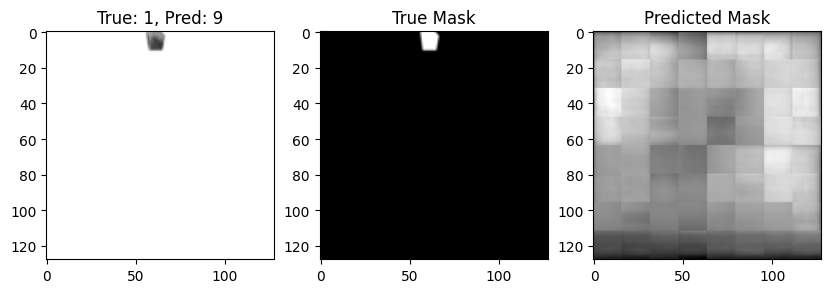

Sample 9:
  True BBox: [  0. 483. 116.  75.], Predicted BBox: [ 15.667523  30.60825  585.54724  467.97064 ]


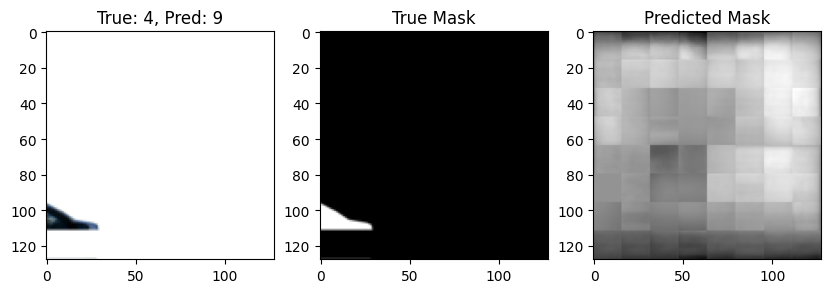

Sample 10:
  True BBox: [ 71. 181.  18.   8.], Predicted BBox: [ 18.753101  21.757065 587.0542   459.3839  ]


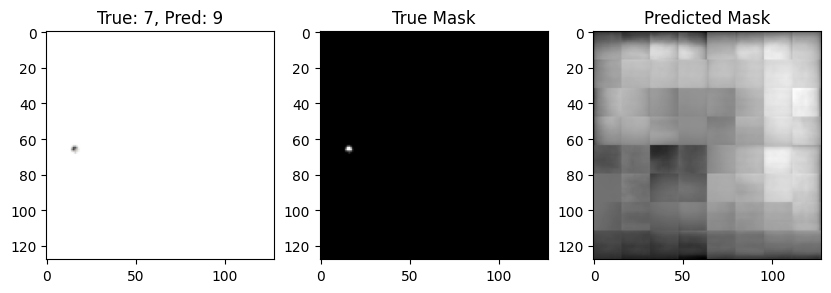

In [11]:
# Visualize 10 test samples
for i, (image, mask, bbox, label, pred_label, pred_mask, pred_bbox) in enumerate(test_samples[:10]):
    plt.figure(figsize=(10, 5))
    plt.subplot(1, 3, 1)
    plt.imshow(image.permute(1, 2, 0))
    plt.title(f"True: {label}, Pred: {pred_label}")

    plt.subplot(1, 3, 2)
    plt.imshow(mask.squeeze(), cmap="gray")
    plt.title("True Mask")

    plt.subplot(1, 3, 3)
    plt.imshow(pred_mask.squeeze(), cmap="gray")
    plt.title("Predicted Mask")

    print(f"Sample {i + 1}:")
    print(f"  True BBox: {bbox.numpy()}, Predicted BBox: {pred_bbox.numpy()}")
    plt.show()